# Cálculo da Diversidade

Neste notebook, repetimos as implementações [1](1-artificial-evolution-simple-model.ipynb) e [2](2-first-deap-simple-example.ipynb). No entanto, incluímos aqui o cálculo da diversidade utilizando a distância de Hamming.

A *distância de Hamming* entre duas sequências de mesmo comprimento é definida como o número de posições em que os elementos correspondentes são diferentes. Formalmente, dada duas strings binárias $x, y \in \{0,1\}^n$, a distância de Hamming é dada por:

$$
d_H(x, y) = \sum_{i=1}^{n} \delta(x_i, y_i)
$$

sendo

$$
\delta(x_i, y_i)=\begin{cases}
1, & x_i\neq y_i,\\
0, & x_i=y_i.
\end{cases}
$$


### 📌 Função para cômputo da diversidade

Seja $P=\{c_1, c_2, ..., c_N\}$ uma população. O calculo da diversidade é dado por:

$$
\mu(P) = \frac{2}{N^2-N}\sum_{i=0}^N\sum_{j=i+1}^N d_H(c_i, c_j)
$$

está é a média da distância de Hamming entre todos os pares de indivíduos (cromossomos) na população $P$.

In [1]:
def calculate_diversity(population):
    """Calcula a diversidade da população usando a distância média de Hamming."""
    num_individuals = len(population)
    total_distance = 0

    # Itera sobre todos os pares de indivíduos
    for i in range(num_individuals):
        for j in range(i + 1, num_individuals):
            # Calcula a distância de Hamming entre dois indivíduos
            distance = sum(g1 != g2 for g1, g2 in zip(population[i], population[j]))
            total_distance += distance

    # Calcula a distância média
    num_pairs = num_individuals * (num_individuals - 1) / 2
    average_distance = total_distance / num_pairs if num_pairs > 0 else 0

    return average_distance

### 📌 Parâmetros para as simulações

In [2]:
# Parâmetros da simulação
GENE_LENGTH = 32    # Número de bits por indivíduo
POP_SIZE = 64       # Tamanho da população
MUTATION_RATE = 0.8 # Probabilidade de ocorrencia de mutação
MTPB = 0.1          # Probabilidade de mutação por gene
CXPB = 0.5          # Probabilidade de crossover
GENERATIONS = 100    # Número de gerações

### 📌 Implementação sem uso de bibliotecas

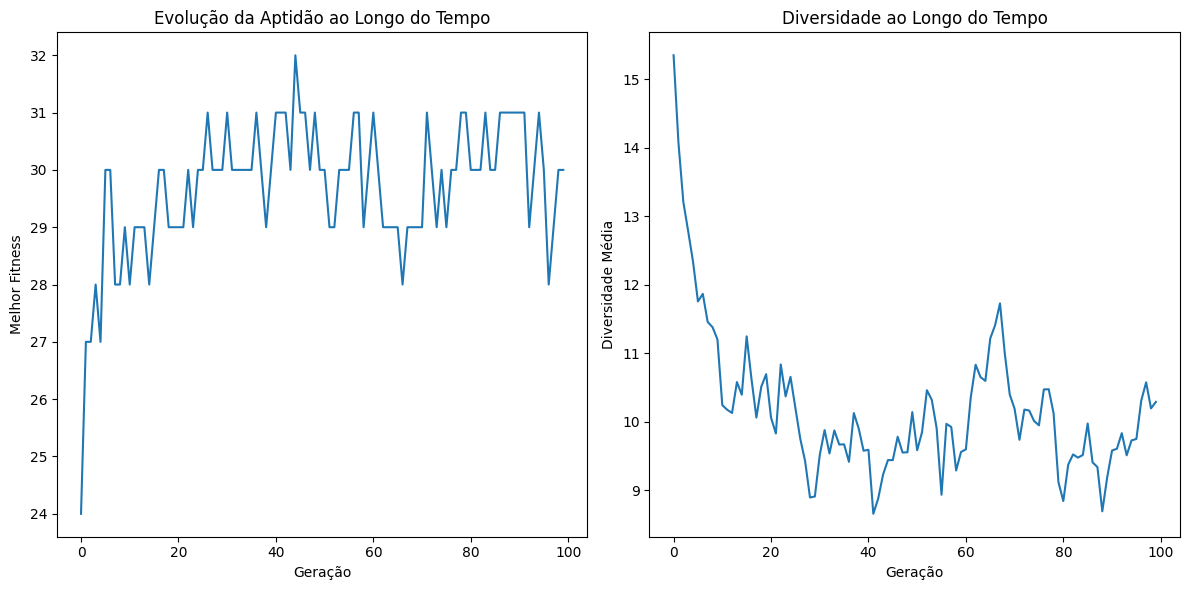

In [3]:
import random
import matplotlib.pyplot as plt

# Criando um indivíduo aleatório (genótipo como string binária)
def create_individual():
    return [random.randint(0, 1) for _ in range(GENE_LENGTH)]

# Criando a população inicial
def initialize_population(size):
    return [create_individual() for _ in range(size)]

def fitness(individual):
    return sum(int(gene) for gene in individual)  # Conta os '1's

def tournament_selection(population, k=3):
    selected = random.sample(population, k)  # Escolhe k indivíduos aleatoriamente
    return max(selected, key=fitness)  # Retorna o mais apto

def crossover(parent1, parent2):
    point = random.randint(1, GENE_LENGTH - 1)  # Escolhe um ponto de corte
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def mutate(individual):
    for i in range(len(individual)):
        if random.random() < MTPB:
            individual[i] = type(individual[i])(not individual[i])            
    return individual

def evolve():
    population = initialize_population(POP_SIZE)
    best_fitness_over_time = []
    diversity = []

    for generation in range(GENERATIONS):
        new_population = []

        # Gera nova população
        while len(new_population) < POP_SIZE:
            # Torneio para seleção de pais
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            # Probabilidade de ocorrencia de cruzamento
            if random.random() < CXPB:
                # Gera dois filhos do cruzamento
                child1, child2 = crossover(parent1, parent2)
                
                if random.random() < MUTATION_RATE:
                    # Aplica mutação 
                    child1 = mutate(child1)
                    child2 = mutate(child2)
                    
                # Inclui à nova população
                new_population.extend([child1, child2])

        # Atualiza população e coleta dados
        population = sorted(new_population, key=fitness, reverse=True)[:POP_SIZE]
        best_fitness = fitness(population[0])
        best_fitness_over_time.append(best_fitness)
        diversity.append(calculate_diversity(population))

    return best_fitness_over_time, diversity

# Executa a simulação
best_fitness, diversity = evolve()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
plt.plot(best_fitness)
plt.xlabel("Geração")
plt.ylabel("Melhor Fitness")
plt.title("Evolução da Aptidão ao Longo do Tempo")

plt.subplot(1, 2, 2) 
plt.plot(diversity)
plt.xlabel("Geração")
plt.ylabel("Diversidade Média")
plt.title("Diversidade ao Longo do Tempo")

plt.tight_layout()
plt.show()

### 📌 Implementação com uso da bibliotéca DEAP

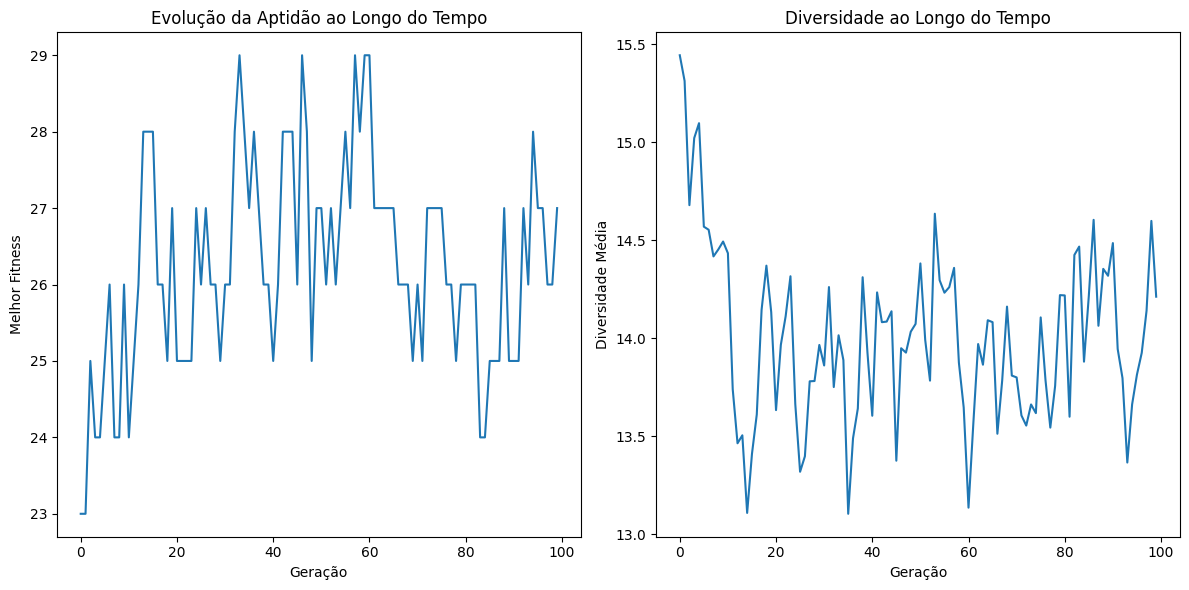

In [4]:

import random
import matplotlib.pyplot as plt
from deap import base, creator, tools

# Criando classe de fitness e indivíduo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizar fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# Registrando funções básicas
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)  # Gera um gene (0 ou 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, GENE_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Função de fitness (quantidade de '1's)
def evaluate(individual):
    return sum(individual),  # Retorna tupla

toolbox.register("mate", tools.cxOnePoint)         # Crossover de um ponto
toolbox.register("mutate", tools.mutFlipBit, indpb=MTPB)  # Mutação por bit
toolbox.register("select", tools.selTournament, tournsize=3)  # Seleção por torneio
toolbox.register("evaluate", evaluate)

# Evolução
def evolve_deap():
    population = toolbox.population(n=POP_SIZE)
    fitness_values = []

    # Avaliação inicial
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)

    diversity = []
    
    for gen in range(GENERATIONS):
        new_population = []
        
        while len(new_population) < POP_SIZE:
            parent1 = toolbox.select(population, 1)[0]
            parent2 = toolbox.select(population, 1)[0]
            
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2)
                                    
                if random.random() < MUTATION_RATE:
                    child1 = toolbox.mutate(child1)[0]
                    child2 = toolbox.mutate(child2)[0]
                    
                new_population.append(creator.Individual(child1))
                new_population.append(creator.Individual(child2))
                
        for ind in new_population:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)

        # Substituir a população
        population[:] = new_population

        # Coleta de dados
        best_fitness = max(ind.fitness.values[0] for ind in population)
        fitness_values.append(best_fitness)
        diversity.append(calculate_diversity(population))

    return fitness_values, diversity


# Executa a simulação
best_fitness, diversity = evolve_deap()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
plt.plot(best_fitness)
plt.xlabel("Geração")
plt.ylabel("Melhor Fitness")
plt.title("Evolução da Aptidão ao Longo do Tempo")

plt.subplot(1, 2, 2) 
plt.plot(diversity)
plt.xlabel("Geração")
plt.ylabel("Diversidade Média")
plt.title("Diversidade ao Longo do Tempo")

plt.tight_layout()
plt.show()

### 📌 Implementação com DEAP e melhorias no algoritmo

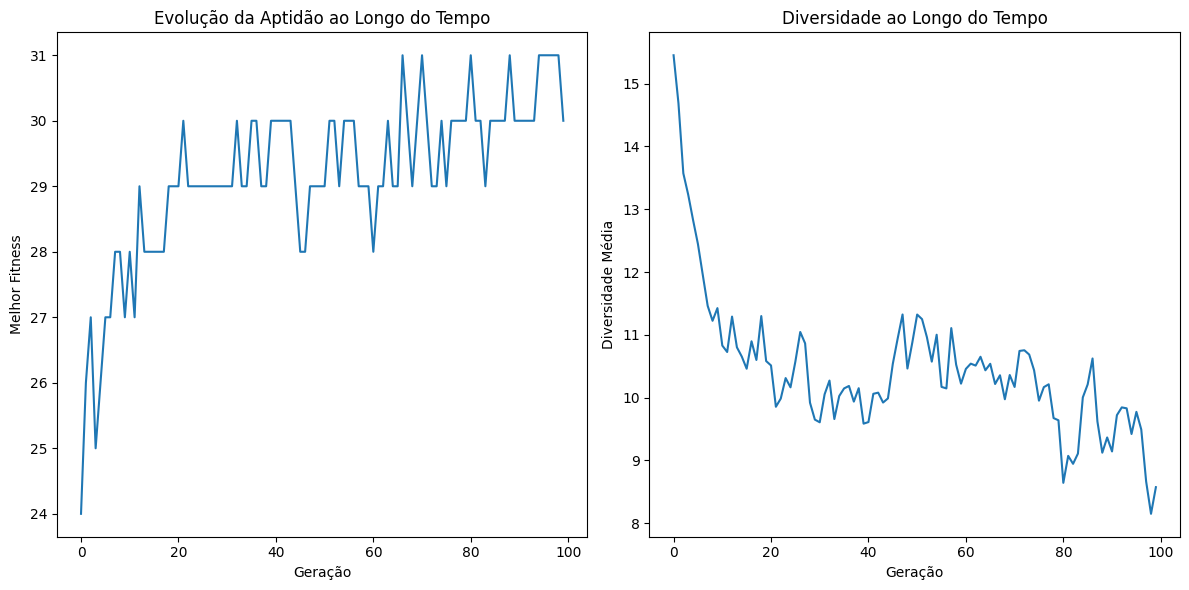

In [6]:
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools

# Criando classe de fitness e indivíduo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizar fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

# Registrando funções básicas
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)  # Gera um gene (0 ou 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, GENE_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Função de fitness (quantidade de '1's)
def evaluate(individual):
    return sum(individual),  # Retorna tupla

toolbox.register("mate", tools.cxOnePoint)         # Crossover de um ponto
toolbox.register("mutate", tools.mutFlipBit, indpb=MTPB)  # Mutação por bit
toolbox.register("select", tools.selTournament, tournsize=3)  # Seleção por torneio
toolbox.register("evaluate", evaluate)

# Evolução
def evolve_deap():
    population = toolbox.population(n=POP_SIZE)
    fitness_values = []

    # Avaliação inicial
    for ind in population:
        ind.fitness.values = toolbox.evaluate(ind)

    diversity = []

    for gen in range(GENERATIONS):
        offspring = toolbox.select(population, len(population))  # Seleciona
        offspring = list(map(toolbox.clone, offspring))  # Clona indivíduos

        # Aplicando crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        # Aplicando mutação
        for mutant in offspring:
            if random.random() < MUTATION_RATE:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Reavaliação dos indivíduos alterados
        for ind in offspring:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)

        # Substituir a população
        population[:] = offspring

        # Coleta de dados
        best_fitness = max(ind.fitness.values[0] for ind in population)
        fitness_values.append(best_fitness)
        diversity.append(calculate_diversity(population))

    return fitness_values, diversity


# Executa a simulação
best_fitness, diversity = evolve_deap()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) 
plt.plot(best_fitness)
plt.xlabel("Geração")
plt.ylabel("Melhor Fitness")
plt.title("Evolução da Aptidão ao Longo do Tempo")

plt.subplot(1, 2, 2) 
plt.plot(diversity)
plt.xlabel("Geração")
plt.ylabel("Diversidade Média")
plt.title("Diversidade ao Longo do Tempo")

plt.tight_layout()
plt.show()